<a href="https://colab.research.google.com/github/alok13/Machine-Learning/blob/master/Gender_Classification_FastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

In [0]:
bs = 64

In [21]:
! git clone https://github.com/alok13/ML_DataSets.git

Cloning into 'ML_DataSets'...
remote: Enumerating objects: 3308, done.
remote: Total 3308 (delta 0), reused 0 (delta 0), pack-reused 3308
Receiving objects: 100% (3308/3308), 596.78 MiB | 37.50 MiB/s, done.
Checking out files: 100% (3330/3330), done.


In [22]:
women=os.listdir("ML_DataSets/data/women")
women_len=len(women)

men=os.listdir("ML_DataSets/data/men")
men_len=len(men)

classes =["men","women"]

train_men_size=int(round(men_len*0.8))
train_women_size=int(round(women_len*0.8))

base_dir="ML_DataSets/data"
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'valid', cl)):
      os.makedirs(os.path.join(base_dir, 'valid', cl))
    shutil.move(v, os.path.join(base_dir, 'valid', cl))


men: 1418 Images
women: 1912 Images


ImageNet structure expect folders to be **train** and **valid** not ***val***

In [0]:

data = ImageDataBunch.from_folder(base_dir, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

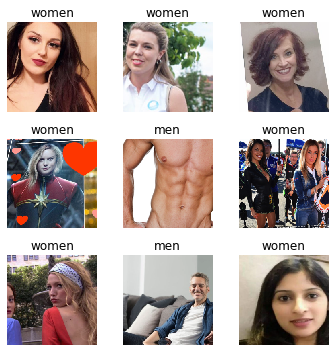

In [14]:
data.show_batch(rows=3, figsize=(5,5))

In [24]:
print(data.classes)
len(data.classes),data.c

['men', 'women']


(2, 2)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [17]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [26]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.704337,0.407718,0.133634,02:21
1,0.490860,0.311882,0.127628,02:18
2,0.365701,0.286443,0.115616,02:14
3,0.302740,0.273494,0.115616,02:20


In [0]:
learn.save('stage-1')

In [28]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

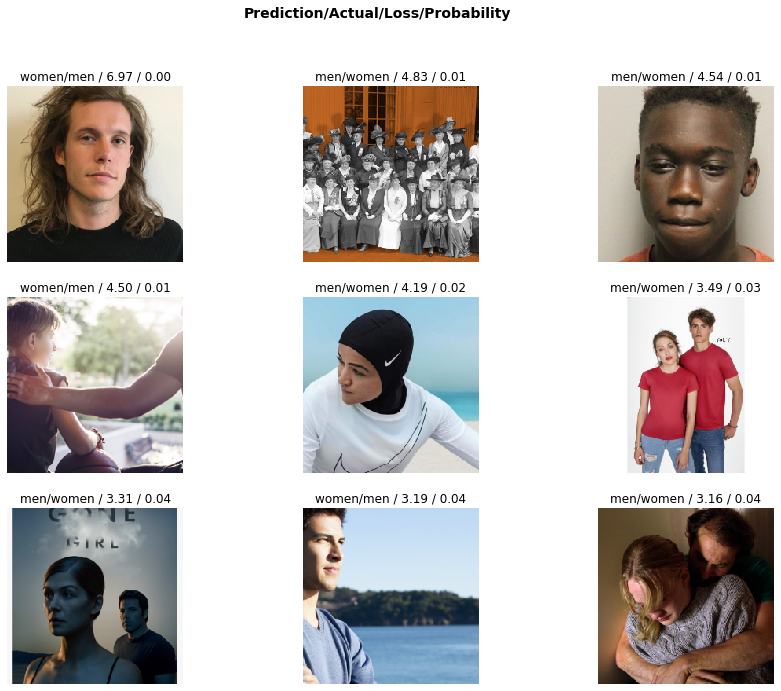

In [29]:
interp.plot_top_losses(9, figsize=(15,11))

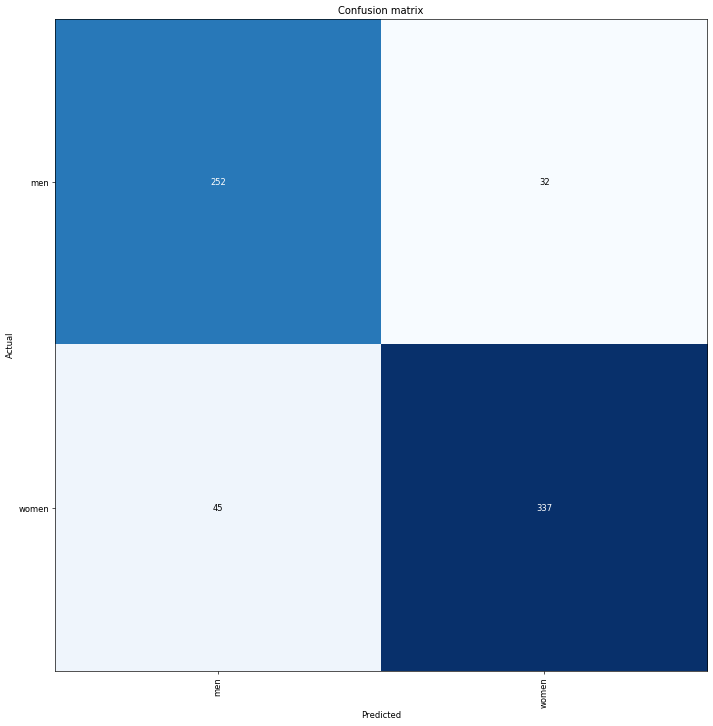

In [30]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [32]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.324063,0.257692,0.115616,02:20


In [33]:
learn.load('stage-1')
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


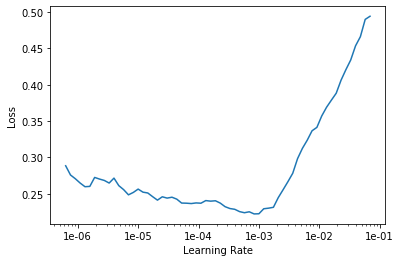

In [34]:
learn.recorder.plot()

In [35]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.341950,0.959458,0.183183,02:19
1,0.276350,0.201331,0.088589,02:21


**Here resnet32 helped us to acheive results with only 0.088 % Error rate**

In [0]:
data = ImageDataBunch.from_folder(base_dir, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

In [39]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 65.6MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


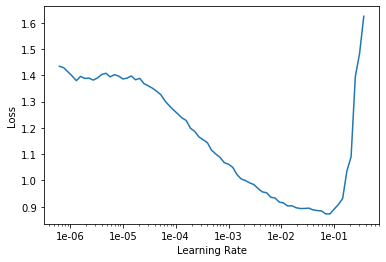

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.639967,0.313694,0.099099,02:33
1,0.500627,0.308247,0.108108,02:27
2,0.376141,0.256895,0.108108,02:28
3,0.277384,0.194559,0.076577,02:23
4,0.217392,0.216328,0.088589,02:31
5,0.190064,0.189924,0.088589,02:27
6,0.165606,0.184745,0.076577,02:21
7,0.142131,0.183325,0.076577,02:24


In [0]:
learn.save('stage-1-50')

In [43]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-3,1e-1))

epoch,train_loss,valid_loss,error_rate,time
0,1.200839,106465.046875,0.573574,02:34
1,1.454203,1.353145,0.426426,02:28
2,1.286728,0.622395,0.324324,02:33


In [44]:
learn.load('stage-1-50')

Learner(data=ImageDataBunch;

Train: LabelList (2664 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
women,women,women,women,women
Path: ML_DataSets/data;

Valid: LabelList (666 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
women,women,women,women,women
Path: ML_DataSets/data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [46]:
interp.most_confused(min_val=2)

[('men', 'women', 27), ('women', 'men', 24)]

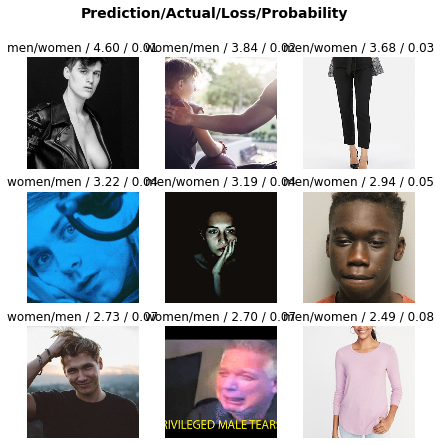

In [47]:
interp.plot_top_losses(9, figsize=(7,7))

**In conclusion , resnet50 predicts images with loss of only 0.076% which is pretty awesome. **